In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import accuracy_score
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from alibi.datasets import fetch_imagenet_10
from alibi.explainers import GradientSimilarity

In [28]:
def plot_similar(ds, expls, int_to_str, mean_channels, figsize=(20, 20)):
    """Plots original instances and similar instances.
    Parameters
    ----------
    ds
     List of dictionaries containing instances to plot, labels and predictions.
    expls
     Similarity explainer explanation object.
    int_to_str
     Dictionary mapping label's number to label's names.
    mean_channels
     Mean channels to add to the images for visualization.
    figsize
     Figure size.
    Returns
    ------
    None
    """
    fig, axes = plt.subplots(5, 6, figsize=figsize, sharex=False)
    for j in range(len(ds)):
        d = ds[j]
        axes[j, 0].imshow(BGR_to_RGB(d['x']))
        label_orig = int_to_str[d['y']].split(',')[0]
        if len(label_orig) > 16:
            label_orig = label_orig[:13] + '...'
        pred_orig = int_to_str[d['pred']].split(',')[0]
        if len(pred_orig) > 16:
            pred_orig = pred_orig[:13] + '...'
        if j == 0:
            title_orig = "Original instance"
            axes[j, 0].set_title(f"{title_orig} \n" +
                                 f"{len(title_orig) * '='} \n" +
                                 f"Label: {label_orig} \n" +
                                 f"Prediction: {pred_orig} ")
        else:
            axes[j, 0].set_title(f"Label: {label_orig} \n" +
                                 f"Prediction: {pred_orig} ")
        axes[j, 0].axis('off')
        for i in range(expls.data['most_similar'].shape[0]):
            label_sim = int_to_str[d['y_sim'][i]].split(',')[0]
            if len(label_sim) > 16:
                label_sim = label_sim[:13] + '...'
            pred_sim = int_to_str[d['preds_sim'][i]].split(',')[0]
            if len(pred_sim) > 16:
                pred_sim = pred_sim[:13] + '...'
            most_similar = BGR_to_RGB((expls.data['most_similar'][j] + mean_channels).astype(int)[i])
            axes[j, i + 1].imshow(most_similar, cmap='gray')
            if j == 0:
                title_most_sim = f"{i+1}{append_int(i+1)} most similar instance"
                axes[j, i + 1].set_title(f"{title_most_sim} \n" +
                                         f"{len(title_most_sim) * '='} \n"+
                                         f"Label: {label_sim} \n" +
                                         f"Prediction: {pred_sim}")
            else:
                axes[j, i + 1].set_title(f"Label: {label_sim} \n" +
                                         f"Prediction: {pred_sim}")
            axes[j, i + 1].axis('off')
    plt.show()

In [29]:
def plot_distributions(ds, expls, int_to_str, figsize=(20, 20)):
    """Plots original instances and scores distributions per class.
    Parameters
    ----------
    ds
      List of dictionaries containing instances to plot, labels and predictions.
    expls
      Similarity explainer explanation object.
    int_to_str
      Dictionary mapping label's number to label's names.
    figsize
      Figure size.
    Returns
    ------
    None
    """
    fig, axes = plt.subplots(5, 2, figsize=figsize, sharex=False)
    for i in range(len(ds)):
        d = ds[i]
        y_sim = d['y_sim']
        preds_sim = d['preds_sim']
        y = d['y']
        pred = d['pred']
        df_ditribution = pd.DataFrame({'y_sim': y_sim,'scores': expls.data['scores'][i]})
        
        axes[i, 0].imshow(BGR_to_RGB(d['x']))
        if i == 0:
            title_orig = "Original instance"
            axes[i, 0].set_title(f"{title_orig} \n " +
                                 f"{len(title_orig) * '='} \n" +
                                 f"Label: {d['y']} - {int_to_str[d['y']]} \n" +
                                 f"Prediction: {d['pred']} - {int_to_str[d['pred']].split(',')[0]} ")
        else:
            axes[i, 0].set_title(f"Label: {d['y']} - {int_to_str[d['y']].split(',')[0]} \n" +
                                 f"Prediction: {d['pred']} - {int_to_str[d['pred']].split(',')[0]} ")

        axes[i, 0].axis('off')
        df_y = df_ditribution.groupby('y_sim')['scores'].mean()
        df_y.index = [int_to_str[i] for i in df_y.index]
        df_y.sort_values(ascending=True).plot(kind='barh', ax=axes[i, 1])

        if i == 0:
            title_true_class = "Averaged scores for each true class in reference set"
            axes[i, 1].set_title(f"{title_true_class} \n" +
                                 f"{len(title_true_class) * '='} \n ")
    
    fig.tight_layout()
    plt.show()

In [30]:
def append_int(num):
    """Converts an integer into an ordinal (ex. 1 -> 1st, 2 -> 2nd, etc.).
    Parameters
    ----------
    num
      Integer number.
    Returns
    -------
    Ordinal suffixes.
    """
    if num > 9:
        secondToLastDigit = str(num)[-2]
        if secondToLastDigit == '1':
            return 'th'
    lastDigit = num % 10
    if (lastDigit == 1):
        return 'st'
    elif (lastDigit == 2):
        return 'nd'
    elif (lastDigit == 3):
        return 'rd'
    else:
        return 'th'


In [31]:
def substract_mean_channel(X):
    """Substracts the mean channels from a batch of images. 
    모형의 성능을 높히기 위해 mean을 빼주어 흑백이미지를 만듬
    (0.7accuracy를 0.86으로 향상시킴)
    Parameters
    ----------
    X
      Batches of images to substract the mean channel from.
    Returns
    -------
    Batch of images.
    """
    assert len(X.shape) == 4
    mean_channels = np.array([103.939, 116.779, 123.68]).reshape(1, 1, 1, -1)
    X_mean = X - mean_channels
    return X_mean, mean_channels

def BGR_to_RGB(X):
    if len(X.shape) == 4:
        return X[:, :,:,::-1]
    elif len(X.shape) == 3:
        return X[:,:,::-1]
    else:
        raise ValueError('Incorrect shape')

In [32]:
imagenet10 = fetch_imagenet_10()

In [33]:
X_train, y_train = imagenet10['trainset']
X_train, mean_channels = substract_mean_channel(X_train)
X_test, y_test = imagenet10['testset']
X_test, _ = substract_mean_channel(X_test)
int_to_str = imagenet10['int_to_str_labels']
y_train = to_categorical(y_train, num_classes=1000)
y_test = to_categorical(y_test, num_classes=1000)

Label: 6 - stingray


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


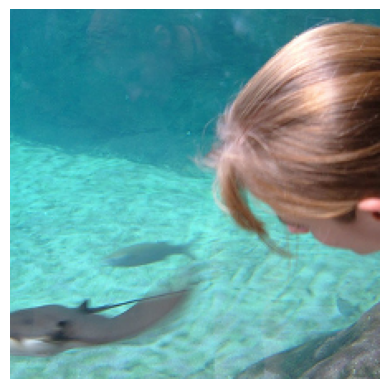

In [34]:
i = 0
label = y_train.argmax(axis=1)[i]
print(f"Label: {label} - {int_to_str[label]}")
x_org= BGR_to_RGB(X_train.astype(int)[i])
plt.imshow(x_org);
x = BGR_to_RGB((X_train + mean_channels).astype(int)[i])
plt.imshow(x);
plt.axis('off');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


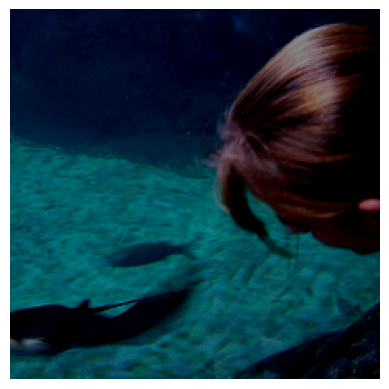

In [35]:
x_org= BGR_to_RGB(X_train.astype(int)[i])
plt.imshow(x_org);
plt.axis('off');

In [36]:
model = ResNet50(weights='imagenet')
preds = model(X_test).numpy().argmax(axis=1)
acc = accuracy_score(y_test.argmax(axis=1), preds)

In [37]:
 print('Test accuracy: ', acc)

Test accuracy:  0.86


In [38]:
gsm = GradientSimilarity(model, categorical_crossentropy, precompute_grads=False, sim_fn='grad_cos')

Found 106 non-trainable parameters in the model. These parameters don't have gradients and will not be included in the computation of gradient similarity. This might be because your model has layers that track statistics using non-trainable parameters such as batch normalization layers. In this case, you don't need to worry. Otherwise it's because you have set some parameters to be non-trainable and alibi is letting you know.


In [39]:
gsm.fit(X_train, y_train)

GradientSimilarity(meta={
  'name': 'GradientSimilarity',
  'type': ['whitebox'],
  'explanations': ['local'],
  'params': {
              'sim_fn_name': 'grad_cos',
              'store_grads': False,
              'backend_name': 'tensorflow',
              'task_name': 'classification'}
            ,
  'version': '0.9.0'}
)

In [40]:
idxs_samples = np.array([np.random.choice(range(5 * i, 5 * i + 5)) for i in range(10)])
idxs_samples = np.random.choice(idxs_samples, 5, replace=False)
X_sample, y_sample = X_test[idxs_samples], y_test[idxs_samples]
preds = model(X_sample).numpy().argmax(axis=1)

In [41]:
expls = gsm.explain(X_sample, y_sample)

In [42]:
print(expls.meta.keys())
print(expls.data.keys())

dict_keys(['name', 'type', 'explanations', 'params', 'version'])
dict_keys(['scores', 'ordered_indices', 'most_similar', 'least_similar'])


In [43]:
ds = []
for j in range(len(X_sample)):
    y_sim = y_train[expls.data['ordered_indices'][j]].argmax(axis=1)
    X_sim = X_train[expls.data['ordered_indices'][j][:5]]
    preds_sim = model(X_sim).numpy().argmax(axis=1)

    d = {'x': (X_sample + mean_channels).astype(int)[j],
         'y': y_sample[j].argmax(),
         'pred':preds[j],
         'y_sim': y_sim,
         'preds_sim': preds_sim}
    ds.append(d)


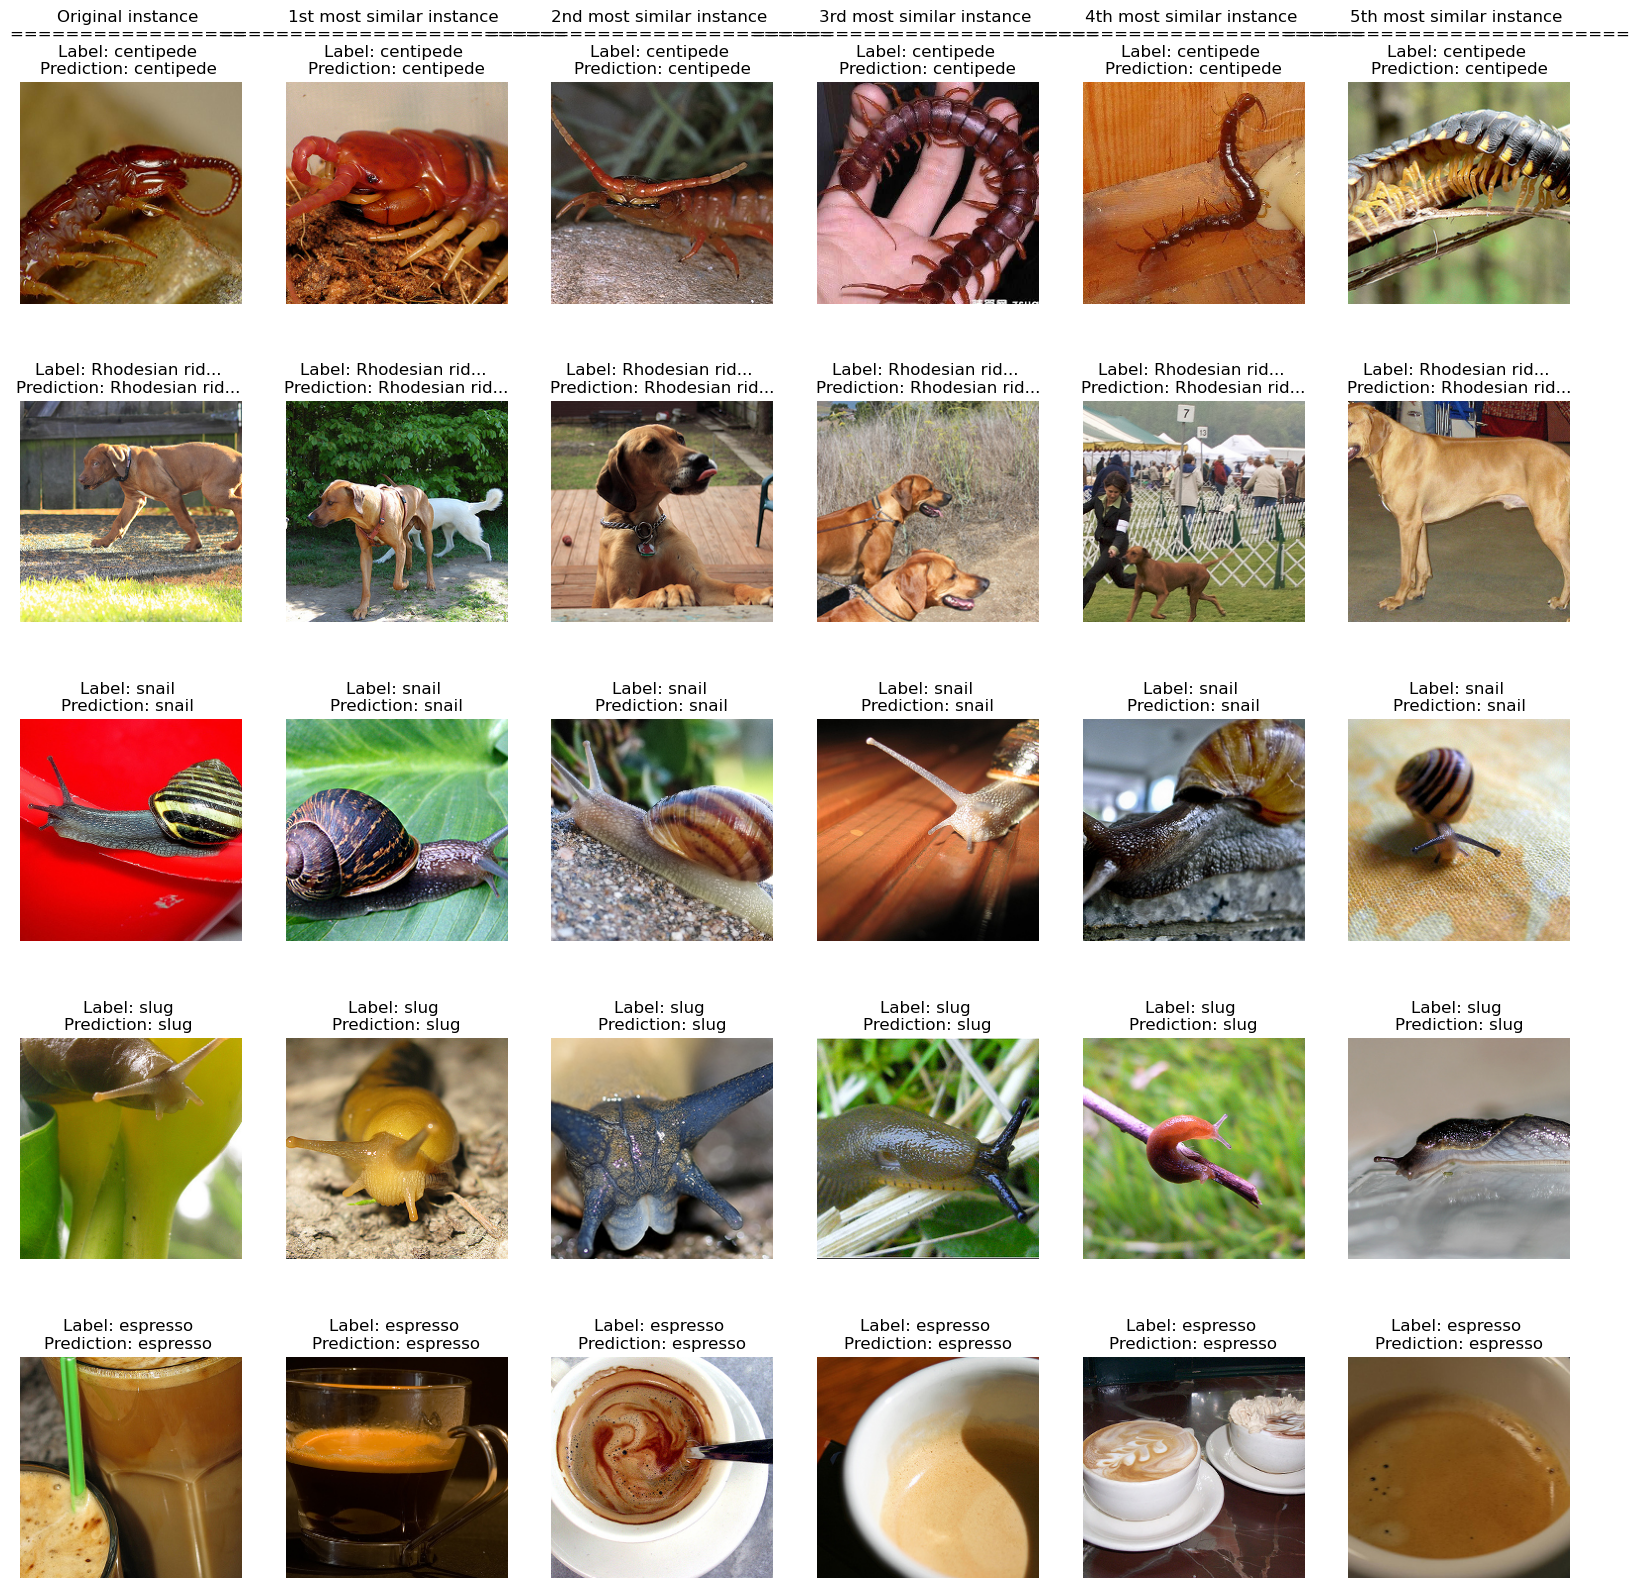

In [44]:
plot_similar(ds, expls, int_to_str, mean_channels)

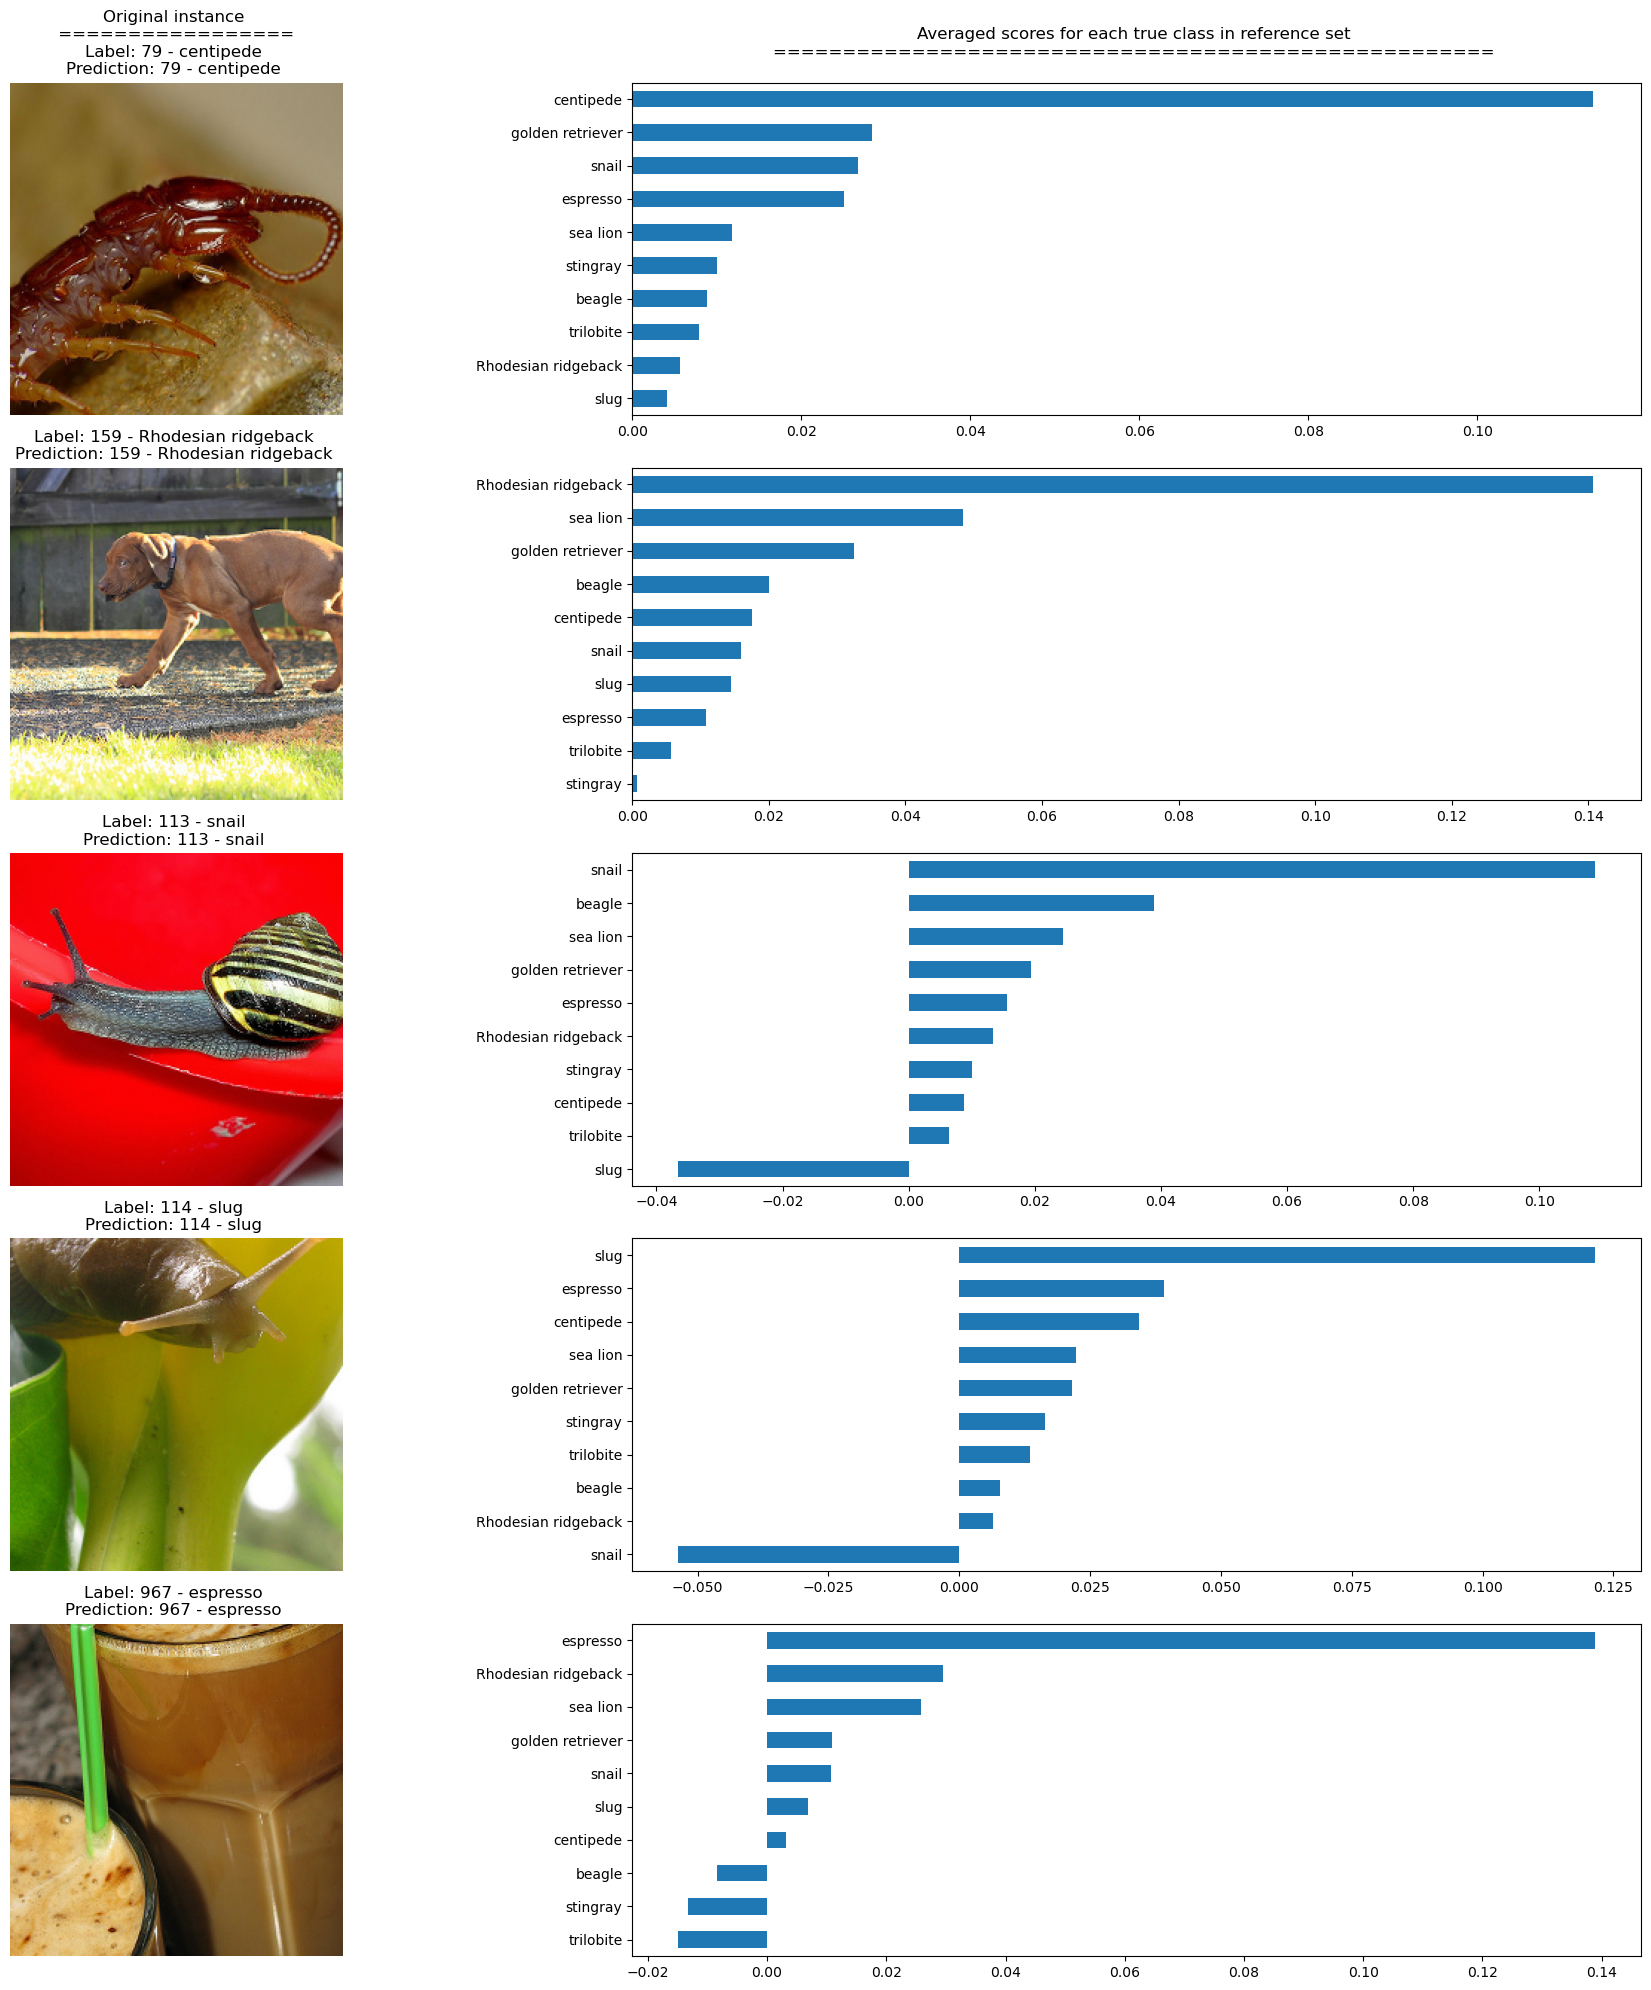

In [45]:
plot_distributions(ds, expls, int_to_str)